# 1. PARAMETERS

In [1]:
####### CONFIGURATION

class CFG:

    # environment
    environment = 'local'  # work environment ['kaggle', 'local']
    device      = 'GPU'    # device ['CPU', 'GPU', 'TPU']
    gpu_index   = 1        # GPU device index
    cpu_workers = 4        # no. CPU cores (data loading)
    tpu_workers = 8        # no. TPU cores [1, 8]

    # general
    version  = 17     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 13353  # random state

    # data
    num_folds = 5      # number of CV folds
    data_pl   = False  # False or percentage of appended pseudo-labeled data 
    
    # image augmentations
    image_size   = 260               # image size after random crop
    num_channels = 3                 # number of color channels
    smart_crop   = False             # smart crop around the drawing
    morphology   = True              # apply morphological transformations
    ssr          = [0.01, 0.01, 10]  # shift, scale, rotation limits
    p_aug        = 0.5               # prob. of augmentations except for flips
    meta_data    = False             # include image meta-data as features
    normalize    = False             # pixel normalization [False, 'imagenet', 'custom']

    # encoder architecture
    backbone       = 'tf_efficientnet_b5_ns'  # CNN backbone   
    encoder_dim    = 2048                   # encoder size (CNN feature vector)
    
    # decoder architecture
    decoder_dim    = 512  # decoder size 
    embed_dim      = 256  # embedding size
    attention_dim  = 256  # attention size
    max_len        = 275  # maximum sequence length
    dropout        = 0.5  # dropout probability
    
    # pretrained weights
    pretrained = 'imagenet'  # pretrained weights [False, 'imagenet', path]
    
    # training
    num_epochs    = 10     # no. epochs per fold
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_size    = 64     # no. images per batch
    accum_iter    = 1      # no. batches for gradient accumalation
    use_amp       = True   # automated mixed precision mode
    grad_clip     = False  # max gradient norm (False or float)
    batch_verbose = 6000   # print loss every n batches
    save_all      = False  # save weights from each epoch
    
    # inference
    valid_batch_size = 512    # no. images per batch on inference
    valid_subset     = False  # no. images in validation subset (False or int)
    beam_k           = 5      # top-k for beam search (submission only)

    # learning rate and optimizer
    cnn_eta = 2e-4     # CNN starting learning rate
    rnn_eta = 8e-4     # RNN starting learning rate
    eta_min = 1e-6     # ending learning rate
    optim   = 'AdamP'  # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    decay   = 1e-6     # weight decay of optimizer (L2 regularization)

    # learning rate scheduler
    warmup          = 1                  # no. epochs for warmup
    schedule        = 'CosineAnnealing'  # LR scheduler after warmup
    update_on_batch = True               # update LR after every batch (or epoch)

    # loss function
    loss_fn = 'CE'  # loss ['CE']

In [2]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [3]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['tracking']   = False
    CFG['save_all']   = False
    CFG['num_epochs'] = 3

# 2. PREPARATIONS

## PACKAGES

In [4]:
####### PACKAGES FOR TPU

if CFG['device'] == 'TPU':
        
    # install XLA
    xla_version = 'nightly' # (1.7, 'nightly')
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version $xla_version

    # settings
    import os
    if CFG['environment'] == 'colab':
        assert os.environ['COLAB_TPU_ADDR']
    os.environ['XLA_USE_BF_16'] = '1'
    os.environ['XLA_TENSOR_ALLOCATOR_MAXSIZE'] = '100000000'

    # imports
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.distributed.parallel_loader as pl

In [ ]:
####### PACKAGES

import numpy as np
import pandas as pd
import scipy as sp

from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from scipy.special import softmax

from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler, WeightedRandomSampler
from torch.utils.data.distributed import DistributedSampler
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.nn.utils import clip_grad_norm_
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.autograd import Function

if CFG['environment'] == 'kaggle':
    import sys
    sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
else:
    !pip install git+'https://github.com/rwightman/pytorch-image-models.git'
import timm
from timm.utils import *

import os
import gc
import re
import math
import time
import random
import shutil
import pickle
import sys
from pathlib import Path
from contextlib import contextmanager, suppress
from collections import defaultdict, Counter

!pip install --upgrade -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

!pip install git+'https://github.com/ildoonet/pytorch-gradual-warmup-lr.git'
from warmup_scheduler import GradualWarmupScheduler  

!pip install adamp
from adamp import AdamP

!pip install madgrad
from madgrad import MADGRAD

!pip install Levenshtein
import Levenshtein

import cv2

from tqdm import tqdm

import gc
gc.enable()

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings

In [ ]:
####### MODULES

sys.path.append('../codes')  

# utilities
from utilities import get_score, randomly, smart_print, smart_save, seed_everything, worker_init_fn

# data processing
from preprocessing import smart_crop, pad_image
from data import get_data, get_loaders, ImageData, ImageTestData, bms_collate
from augmentations import get_augs

# tokenizer
from tokenizer import Tokenizer

# model
from model import get_model
from encoder import Encoder
from decoder import _inflate, Attention, DecoderWithAttention, TopKDecoder
from optimizers import get_optimizer, get_scheduler
from losses import get_losses

# training and inference
from training import train_epoch
from validation import valid_epoch, valid_epoch_with_beam_search
from run_fold import run_fold, run_on_tpu
from plot_results import plot_results
    
seed_everything(CFG['seed'], CFG)

## ENVIRONMENT

In [7]:
####### WORKING PATHS

# kaggle
if CFG['environment'] == 'kaggle':
    CFG['data_path']  = '/kaggle/input/bms-molecular-translation/'
    CFG['out_path']   = ''

# local
if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

In [ ]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    
    # install neptune
    !pip install --upgrade neptune-client
    import neptune 

    # create exoeriment
    neptune.init(api_token = 'YOUR-NEPTUNE-TOKEN',
                 project_qualified_name = 'YOUR-NEPTUNE-PROJECT')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

In [9]:
####### TRAINING DEVICE

if CFG['device'] == 'TPU':
    print('Training on TPU...')
    device      = torch.device('cpu')
    serial_exec = xmp.MpSerialExecutor()
    
if CFG['device'] == 'GPU':
    print('Training on GPU {}...'.format(CFG['gpu_index']))
    device = torch.device('cuda:{}'.format(CFG['gpu_index']))

if CFG['device'] == 'CPU':
    print('Training on CPU...')
    device = torch.device('cpu') 

Training on GPU 1...


In [10]:
####### ENVIRONMENT SETTINGS

warnings.filterwarnings('ignore')       # ignoring warnings
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'], CFG)       # random seed

- setting random seed to 13353...


# 3. DATA PREP

In [11]:
####### DATA PROCESSING

# import
if CFG['environment'] == 'local':
    df = pd.read_pickle(CFG['data_path'] + 'train2.pkl')
elif CFG['environment'] == 'kaggle':
    df = pd.read_pickle('../input/inchi-preprocess-2/train2.pkl')

# update paths
def get_train_file_path(image_id):
    return CFG['data_path'] + 'train/{}/{}/{}/{}.png'.format(image_id[0], image_id[1], image_id[2], image_id )
df['file_path'] = df['image_id'].apply(get_train_file_path)

# partitioning
skf = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'])
for fold, (trn_idx, val_idx) in enumerate(skf.split(df, df['InChI_length'])):
    df.loc[val_idx, 'fold'] = fold
df['fold'] = df['fold'].astype(int)
df['fold'].value_counts()

0    484838
1    484837
2    484837
3    484837
4    484837
Name: fold, dtype: int64

In [15]:
####### TOKENIZER

if CFG['environment'] == 'local':
    tokenizer = torch.load(CFG['data_path'] + 'tokenizer2.pth')
elif CFG['environment'] == 'kaggle':
    tokenizer = torch.load('../input/inchi-preprocess-2/tokenizer2.pth')

- batch shape:  torch.Size([5, 3, 260, 260]) vs torch.Size([5, 3, 260, 260])
- loading time: 2.4786 vs 0.3008 seconds
- pixel values: 0.00 - 0.97 - 1.00 vs 0.00 - 0.97 - 1.00


32

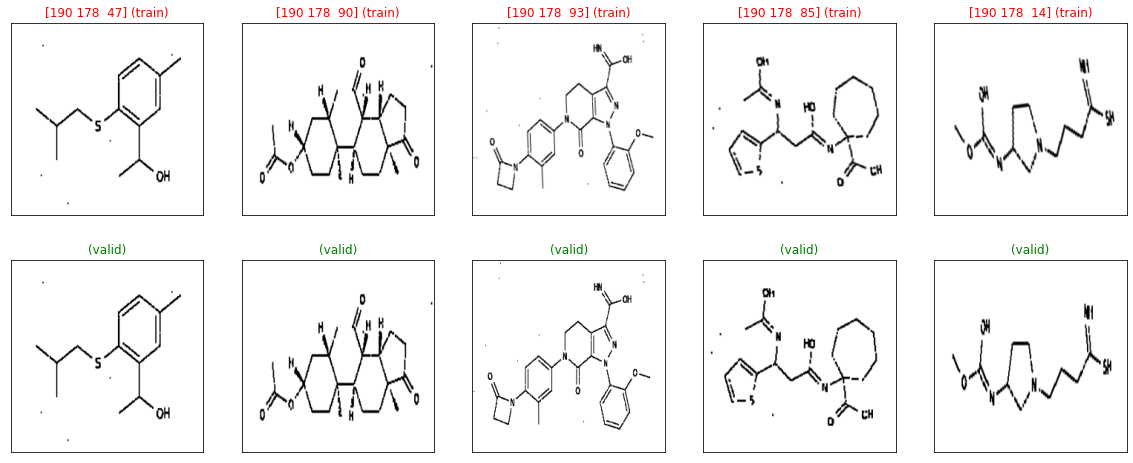

In [17]:
####### EXAMINE SAMPLE BATCH

# sample size
sample = 5

# augmentations
train_augs, valid_augs = get_augs(CFG, image_size = CFG['image_size'])

# datasets
train_dataset = ImageData(df         = df.head(sample), 
                          tokenizer  = tokenizer,
                          channels   = CFG['num_channels'],
                          crop       = CFG['smart_crop'],
                          morphology = CFG['morphology'],
                          meta       = CFG['meta_data'],
                          transform  = train_augs)
valid_dataset = ImageTestData(df         = df.head(sample), 
                              channels   = CFG['num_channels'],
                              crop       = CFG['smart_crop'],
                              morphology = CFG['morphology'],
                              meta       = CFG['meta_data'],
                              transform  = valid_augs)

# data loaders
train_loader = DataLoader(dataset     = train_dataset, 
                          batch_size  = sample, 
                          shuffle       = False, 
                          num_workers = CFG['cpu_workers'],
                          drop_last   = True, 
                          collate_fn  = bms_collate)
valid_loader = DataLoader(dataset     = valid_dataset, 
                          batch_size  = sample, 
                          shuffle       = False, 
                          num_workers = CFG['cpu_workers'],
                          drop_last   = False)

# display train images
batch_time = time.time()
for batch_idx, (inputs, labels, lengths) in enumerate(train_loader):
    
    # extract inputs and labels
    inputs  = inputs.to(device)
    labels  = labels.to(device)
    lengths = lengths.to(device)
    
    # feedback
    inputs_shape = inputs.shape
    load_time    = time.time() - batch_time
    pixel_values = [torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()]

    # examples
    fig = plt.figure(figsize = (20, 8))
    for i in range(sample):
        ax = fig.add_subplot(2, sample, i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].cpu().numpy()[0, :, :], cmap = 'gray')
        ax.set_title('{} (train)'.format(labels[i].cpu().numpy()[0:3]), color = 'red')
    break

# display valid images
batch_time = time.time()
for batch_idx, inputs in enumerate(valid_loader):
                    
    # feedback
    print('- batch shape:  {} vs {}'.format(inputs_shape, inputs.shape))
    print('- loading time: {:.4f} vs {:.4f} seconds'.format(load_time, (time.time() - batch_time)))
    print('- pixel values: {:.2f} - {:.2f} - {:.2f} vs {:.2f} - {:.2f} - {:.2f}'.format(
            pixel_values[0], pixel_values[1], pixel_values[2],
            torch.min(inputs).item(), torch.mean(inputs).item(), torch.max(inputs).item()))

    # examples
    for i in range(sample):
        ax = fig.add_subplot(2, sample, sample + i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].cpu().numpy()[0, :, :], cmap = 'gray')
        ax.set_title('(valid)', color = 'green')
    plt.savefig(CFG['out_path'] + 'fig_sample.png')
    break
    
# clean up
del inputs, labels, lengths, batch_idx, train_loader, valid_loader, train_dataset, valid_dataset
del train_augs, valid_augs, pixel_values, inputs_shape
gc.collect()

# 4. CROSS-VALIDATION

In [ ]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# clear memory
gc.collect()

# amp settings
amp_autocast = suppress
if CFG['use_amp']:
    amp_autocast = torch.cuda.amp.autocast
    scaler       = torch.cuda.amp.GradScaler()

# placeholders
oof = None

# cross-validation
for fold in range(1):
        
    # feedback
    print('-' * 55)
    print('FOLD {:d}/{:d}'.format(fold + 1, CFG['num_folds']))    
    print('-' * 55) 
    
    # prepare model
    encoder, decoder = get_model(CFG, device)
    
    # prepare data
    df_trn, df_val = get_data(df, fold, CFG)  
    
    # training and inference
    if CFG['device'] != 'TPU':
        trn_losses, val_scores, val_preds_best = run_fold(fold, df_trn, df_val, CFG, encoder, decoder, device)
    else:
        xmp.spawn(run_on_tpu, args = (CFG, ), nprocs = CFG['tpu_workers'], start_method = 'fork')
        trn_losses     = np.load('trn_losses.npy')
        val_scores     = np.load('val_scores.npy')
        val_preds_best = np.load('val_preds_best.npy')
            
    # export OOF preds
    val_preds_df = pd.DataFrame(val_preds_best, columns = ['pred'])
    val_preds_df = pd.concat([df_val, val_preds_df], axis = 1)
    oof          = pd.concat([oof,    val_preds_df], axis = 0).reset_index(drop = True)
    oof.to_csv(CFG['out_path'] + 'oof.csv', index = False)
    
    # feedback
    print('-' * 55)
    print('Best: score = {:.4f} (epoch {})'.format(
        np.min(val_scores), np.argmin(val_scores) + 1))
    print('-' * 55)

    # plot loss dynamics
    plot_results(trn_losses, val_scores, fold, CFG)
    
    # send weights to neptune
    if CFG['tracking']:
        neptune.send_artifact(CFG['out_path'] + 'weights_fold{}.pth'.format(fold))

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

In [34]:
####### CHECK OOF PERFORMANCE

# compute score
oof_score = get_score(oof['InChI'], oof['pred'])

# print performance
print('-' * 30)
print('OOF score = {:.4f}'.format(oof_score))
print('-' * 30)

# inspect predictions
for i in range(5): 
    print(oof['pred'][i])
    print('-' * 30)

------------------------------
OOF score = 1.8457
------------------------------
InChI=1S/C61H104O6/c1-4-7-10-13-16-19-22-25-27-29-31-33-35-38-41-44-47-50-53-59(62)65-56-57(55-64-58(61)52-49-46-43-40-37-34-24-21-18-15-12-9-6-3)66-60(63)54-51-48-45-42-39-36-32-30-28-26-23-20-17-14-11-8-5-2/h9,12,15,17-18,20-21,23-24,26-27,29-30,32,35,39,56H,4-8,10-11,13-14,16,19,22,25,28,31,33,36-38,40-56H2,1-3H3/b12-9-,18-15-,20-17-,24-23-,29-27-,31-26-,36-33-
------------------------------
InChI=1S/C59H104O6/c1-4-7-10-13-16-19-22-25-27-29-31-33-36-39-42-45-48-51-57(60)63-54-55(53-62-56(59)50-47-44-41-38-35-32-24-21-18-15-12-9-6-3)64-58(61)52-49-46-43-40-37-34-30-28-26-23-20-17-14-11-8-5-2/h9,12,15,18,21,24,27,29,32,34,37,40,43,46,56H,4-8,10-11,13-14,16-17,19-20,22-23,25-26,28,30-31,33,35-38,40-41,43-52H2,1-3H3/b12-9+,18-15+,24-21+,30-29+,36-33+,42-39+
------------------------------
InChI=1S/C59H98O6/c1-4-7-10-13-16-19-22-25-28-29-30-31-33-35-38-41-44-47-50-53-59(62)65-56-57(55-64-58(61)52-49-46-43-40-

In [35]:
####### EXPORT CONFIGURATION

# store performance values
CFG['time_hours'] = (time.time() - cv_start) / 3600
CFG['oof_score']  = oof_score

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score', oof_score)
    neptune.send_artifact(CFG['out_path'] + 'oof.csv')           
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')

# 5. SUBMISSION

In [36]:
###### DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'sample_submission.csv')
if CFG['debug']:
    sub = sub.head(512 * 8)

# update paths
def get_test_file_path(image_id):
    return CFG['data_path'] + 'test/{}/{}/{}/{}.png'.format(image_id[0], image_id[1], image_id[2], image_id)
sub['file_path'] = sub['image_id'].apply(get_test_file_path)

# display
print(f'test.shape: {sub.shape}')
display(sub.head())

test.shape: (1616107, 3)


,image_id,InChI,file_path
0,50e8e8ede47a,InChI=1S/C59H102O12/c1-4-7-10-13-16-19-22-24-2...,../input/test/5/0/e/50e8e8ede47a.png
1,1b07f0b939a4,InChI=1S/C63H121NO10/c1-3-5-7-9-11-13-15-17-19...,../input/test/1/b/0/1b07f0b939a4.png
2,aca3798223b1,InChI=1S/C59H106O6/c1-6-13-18-23-26-29-32-35-3...,../input/test/a/c/a/aca3798223b1.png
3,85ad5e28e090,InChI=1S/C63H121NO10/c1-3-5-7-9-11-13-15-17-19...,../input/test/8/5/a/85ad5e28e090.png
4,a875b8237b67,InChI=1S/C59H121NO3/c1-3-5-7-9-11-13-15-17-19-...,../input/test/a/8/7/a875b8237b67.png


In [ ]:
###### INFERENCE

# prepare data loader
_, test_augs = get_augs(CFG)
test_dataset = ImageTestData(df        = sub, 
                             transform = test_augs)
test_loader  = DataLoader(test_dataset, 
                          batch_size  = 512, 
                          shuffle       = False,
                          num_workers = CFG['cpu_workers'],
                          pin_memory  = False)

# load best model
encoder, decoder = get_model(CFG, device, pretrained = CFG['out_path'] + 'weights_fold0.pth')
encoder.to(device)
decoder.to(device)

# inference
if CFG['beam_k'] == 1:
    test_preds = valid_epoch(test_loader, encoder, decoder, tokenizer, CFG, device)
elif CFG['beam_k'] > 1:
    test_preds = valid_epoch_with_beam_search(test_loader, encoder, decoder, tokenizer, CFG, device)

In [ ]:
####### EXPORT SUBMISSION

# save submission
sub['InChI'] = ['InChI=1S/{}'.format(p) for p in test_preds]
sub[['image_id', 'InChI']].to_csv(CFG['out_path'] + 'submission.csv', index = False)
display(sub[['image_id', 'InChI']].head())

# send to Neptune
if CFG['tracking']:
    neptune.send_artifact(CFG['out_path'] + 'submission.csv') 
    neptune.stop()